In [108]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import h5py
import gzip
import json
import os
import tqdm

import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [109]:
raw_graph = pd.read_csv('data/travel_graph_country_level.tsv', delimiter='\t')

In [3]:
import json
countries_metadata = json.load(open('data/countries_metadata.json'))

## Country ISO3 to code mapping

In [4]:
countries_iso_to_id_map = dict([(value['country_iso3'], int(key)) for key, value in countries_metadata.items()])

## Construct graph

In [15]:
def construct_adj_matrix(raw_graph, countries_iso_to_id_map):
    """
    raw_graph: list of edges and edge value
    """
    n_countries = len(countries_iso_to_id_map)
    adj_mx = np.zeros((n_countries, n_countries), dtype=np.float)
    for idx, row in raw_graph.iterrows():
        loc_a, loc_b = countries_iso_to_id_map[row['country_i']], countries_iso_to_id_map[row['country_j']]
        adj_mx[loc_a, loc_b] = row['avg_daily_travelers']
        adj_mx[loc_b, loc_a] = row['avg_daily_travelers']
    return adj_mx

In [16]:
adj_mx = construct_adj_matrix(raw_graph, countries_iso_to_id_map)

In [18]:
# Sanity check
(adj_mx.T == adj_mx).all()

True

## Visualize

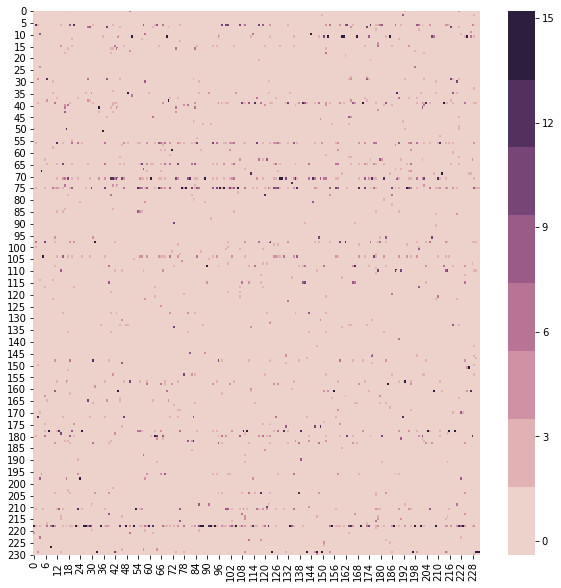

In [19]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap((adj_mx - adj_mx.mean(axis=1))/adj_mx.std(axis=1), cmap=sns.cubehelix_palette(8))

In [96]:
adj_mx[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.85182500e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.21890000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.19085000e+00,
       0.00000000e+00, 4.24480500e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.10870000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.02544750e+01, 1.62312500e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00451725e+02,
       0.00000000e+00, 1.63307500e+00, 1.46907750e+01, 1.10870000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.07845925e+02, 0.00000000e+00, 0.00000000e+00,
       4.52710000e+00, 2.49720000e+00, 2.55525725e+02, 0.00000000e+00,
       1.40760000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

## Save Adj Mx

In [20]:
np.save('data/EpiGCN/adj_mx', adj_mx)

## NetworkX Graph creation

In [48]:
import networkx as nx

G = nx.from_numpy_array(adj_mx, create_using=nx.Graph)

In [53]:
nx.is_frozen(G)

False

## Implement graph clustering

The approach we can try is to use HCS Clustering algorithm based on min-cut algorithm to find sets of highly connected subgraphs

see: https://en.wikipedia.org/wiki/HCS_clustering_algorithm

reference implementation: https://github.com/53RT/Highly-Connected-Subgraphs-Clustering-HCS/blob/master/hcs.py

In [93]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c).copy()

class HCSClustering:
    def is_highly_connected(self, graph, min_cut_edges):
        return len(min_cut_edges) > (len(graph) / 2.0)
    
    def disconnect_components(self, graph, min_cut_edges):
        for edge in min_cut_edges:
            graph.remove_edge(*edge)
        return graph
    
    def hcs(self, graph):
        min_cut_edges = nx.minimum_edge_cut(graph)
        if len(graph) > 2 and not self.is_highly_connected(graph, min_cut_edges):
            graph = self.disconnect_components(graph, min_cut_edges)
            disconnected_components = list(connected_component_subgraphs(graph))
            if len(disconnected_components) > 2:
                raise Exception("more than 2 components")
            c1, c2 = self.hcs(disconnected_components[0]), self.hcs(disconnected_components[1])
            graph = nx.compose(c1, c2)
        return graph

In [111]:
clustered_graph = HCSClustering().hcs(G.copy())

In [114]:
nx.connected_components(clustered_graph)

<generator object connected_components at 0x7fe3de26cdd0>

In [117]:
nx.write_gpickle(clustered_graph, 'data/EpiGCN/hcs_components.gpkl')